## Recon Notebook


In [64]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import math
from PIL import Image
import numpy as np
import skimage.exposure
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as tfs
import torch.optim as optim
import random
device='cuda'
from tqdm import tqdm

## Brats data

In [2]:
class brats_data(Dataset):
    def __init__(self, path='/home/Student/s4606685/png_brats_LGG/'):
        self.all_scans = os.listdir(path)
        self.tensor_transform = tfs.Compose([
            tfs.ToTensor(),
        ])
        self.path = path
        
    def __len__(self):
        return len(self.all_scans)
    
    def __getitem__(self, idx):
        scan = self.all_scans[idx]
        all_t1_images = os.listdir(self.path+scan+'/t1w')
        mid = math.floor(len(all_t1_images)/2)
        
        t1_path = self.path+scan+'/t1w/'+str(mid)+'.png'
        t1_image = self._process_img(t1_path)
        
        mask_path = self.path + scan +'/mask/'+str(mid)+'.png'
        mask_image = self._process_img(mask_path)
        mask_image[mask_image > 0] = 1
        return t1_image, mask_image
    
    def _process_img(self, img_path):
        img = Image.open(img_path)
        img = img.convert('L')
        img = img.resize((128,128))
        img = np.array(img)
        img = self._histogram_match(img)
        if np.max(img)-np.min(img)!= 0:
            img = (img-np.min(img))/(np.max(img)-np.min(img))
        img = np.expand_dims(img, axis=-1)
        img = self.tensor_transform(img)
        return img
        
    def _histogram_match(self, src):
        images = os.listdir('/home/Student/s4606685/summer_research/oasis-3/png_data/T1w-png-converted')
        #num = random.randint(0, len(images))
        num = 3000
        ref = Image.open('/home/Student/s4606685/summer_research/oasis-3/png_data/T1w-png-converted/'+images[num])
        ref = ref.convert('L')
        ref = ref.resize((128, 128))
        ref = np.array(ref)
        #ref = (ref - np.min(ref)) / (np.max(ref) - np.min(ref))
        matched = skimage.exposure.match_histograms(src, ref)
        return matched
        
ds = brats_data('/home/Student/s4606685/png_brats_LGG/')
dl = DataLoader(ds, batch_size=1, shuffle=True)

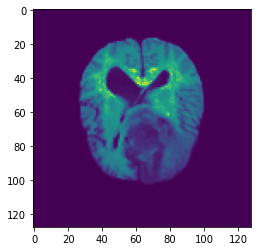

In [11]:
x = next(enumerate(dl))
plt.imshow(x[1][0][0][0])

## Load VAE

In [13]:
vae_path = '/home/Student/s4606685/24_1_22/logsnormalised160.pth'
vae_model = torch.load(vae_path, map_location=torch.device('cuda'))
vae_model.eval()

ConvVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): ResBlock_Down(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): ResBlock_Down(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1,

## Utils

In [107]:
def total_variation(images, name=None):
    """
    Pytorch implementation of tf.image.total_variation for single channel images
    https://github.com/tensorflow/tensorflow/blob/v2.8.0/tensorflow/python/ops/image_ops_impl.py#L3220-L3289

    :param images: Images of shape [batch, height, width]
    :param name: *Redundant*
    :return: Calculated total variation
    """
    ndims = len(list(images.shape))
    if ndims == 3:
        pixel_dif1 = images[:, 1:, :] - images[:, :-1, :]
        pixel_dif2 = images[:, :, 1:] - images[:, :, :-1]
        tot_var = (torch.sum(torch.abs(pixel_dif1)) + torch.sum(torch.abs(pixel_dif2)))
    else:
        raise ValueError('images must have 3 dimensions')
    return tot_var


def histogram_match(src):
    """
    Histogram match src to one of oasis dataset
    :param src: Image to match
    :return: Matched image
    """
    images = os.listdir('/home/Student/s4606685/summer_research/oasis-3/png_data/T1w-png-converted')
    ref = Image.open('/home/Student/s4606685/summer_research/oasis-3/png_data/T1w-png-converted/'+images[3000])
    ref = ref.convert('L')
    ref = ref.resize((128, 128))
    ref = np.array(ref)
    #ref = (ref - np.min(ref)) / (np.max(ref) - np.min(ref))
    matched = skimage.exposure.match_histograms(src, ref)
    return matched

def map_restoration_vae_type1(inpimg, decmu, vae_prior, device='cuda', riter=100, tvweight=1, alpha=0.01):
    """
    :param inpimg: [batch, channels, width, height] Input image (image with lesion)
    :param decmu:  [batch, channels, width, height] Decoded mean for l2 loss calculation
    :param vae_prior: trained VAE prior
    :param device: computation device
    :param riter: reconstruction iters
    :param tvweight: tv_norm weight
    :param alpha: learning rate
    :return: Restored image
    """
    inpimg = nn.Parameter(inpimg, requires_grad=False)
    decmu = nn.Parameter(decmu.float(), requires_grad=False)
    X_i = nn.Parameter(inpimg.clone(), requires_grad=True)

    inpimg = inpimg.to(device)
    decmu = decmu.to(device)
    X_i = X_i.to(device)
    vae_prior = vae_prior.to(device)

    optimizer = optim.Adam([X_i], lr=alpha)
    for i in range(riter):
        _, z_mean, z_cov, _ = vae_prior(X_i.double())
        l2_loss = (decmu.view(-1, decmu.numel()) - X_i.view(-1, X_i.numel())).pow(2)
        kl_loss = -0.5 * torch.sum(1 + z_cov - z_mean.pow(2) - z_cov.exp())
        gradfn = (1)*((torch.sum(l2_loss) + kl_loss) + tvweight * (1)*total_variation((torch.subtract(X_i,inpimg).squeeze(1))))
        gradfn.backward()
        torch.clamp(X_i, -100, 100)
        optimizer.step()
        optimizer.zero_grad()
    return X_i


def map_restoration_vae_type2(Y, decoded_mu, vae_model, recon_iters, tv_weight, step_size, device='cuda'):
    img_ano = nn.Parameter(Y.clone().to(device), requires_grad=True)
    Y = Y.to(device)
    decoded_mu = decoded_mu.to(device)
    for i in range(recon_iters):
        _, z_mean, z_cov, _ = vae_model(img_ano.double())
        kl_loss = -0.5*torch.sum(1+z_cov-z_mean.pow(2)-z_cov.exp())
        l2_loss = (decoded_mu.view(-1, decoded_mu.numel()) - img_ano.view(-1, img_ano.numel())).pow(2)
        elbo = l2_loss + kl_loss
        tv_loss = total_variation((img_ano - Y).squeeze(1))
        loss = (-1)*tv_weight*tv_loss + elbo
        loss_grad = torch.autograd.grad(loss, img_ano, grad_outputs=loss.data.new(loss.shape).fill_(1), create_graph=True)[0]
        loss_grad = torch.clip(loss_grad, min=-100, max=100)
        img_ano_update = img_ano + step_size*loss_grad.detach()
        img_ano = img_ano_update.to(device).detach()
        img_ano.requires_grad = True
    return img_ano

def get_decoded_mu(img1):
    n_latent_samples = 25
    decoded_mu1 = torch.zeros(img1.size())
    for s in range(n_latent_samples):
        recon_batch, z_mean, z_cov, res = vae_model(img1)
        decoded_mu1 += np.array([1 * recon_batch[i].detach().cpu().numpy() for i in range(img1.size()[0])])
    decoded_mu1 = decoded_mu1 / n_latent_samples
    return decoded_mu1

def load_training_image():
    images_all = os.listdir('/home/Student/s4606685/summer_research/oasis-3/png_data/T1w-png-converted')
    random_image = random.randint(0, len(images_all))
    image_path = '/home/Student/s4606685/summer_research/oasis-3/png_data/T1w-png-converted/' + images_all[random_image]
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((128, 128))
    img = np.array(img)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = np.expand_dims(img, axis=-1)
    tensor_transform = tfs.Compose([
        tfs.ToTensor(),
    ])
    img = tensor_transform(img)# (1,1,128,128) tensor
    return img

## Recon test Type1

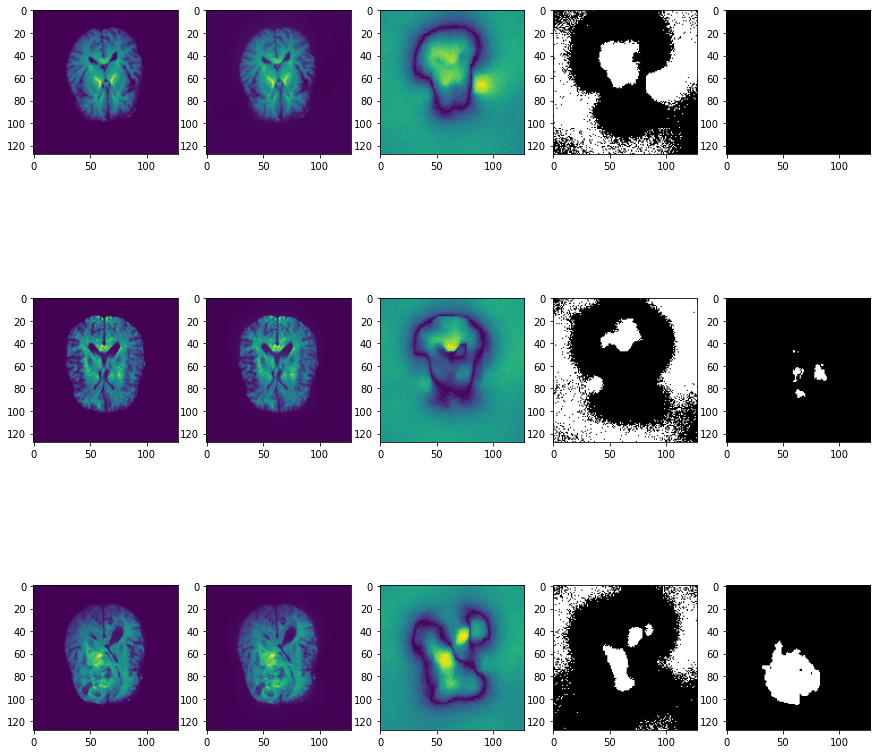

In [62]:
THRESHOLD = 0.03
WEIGHT = 1.7

f, axrr = plt.subplots(3,5)
f.set_figheight(15)
f.set_figwidth(15)

loader = enumerate(dl)
for i in range(3):
    batch, (img, mask) = next(loader)
    clean_mask = img
    img = img.to(device)
    
    clean_mask[clean_mask != 0] = 1
    
    mask=mask.to(device)
    decoded_mu = get_decoded_mu(img)
    img = img
    decoded_mu = decoded_mu
    restored = map_restoration_vae_type1(inpimg=img, decmu=decoded_mu, vae_prior=vae_model, device='cuda', riter=100, tvweight=WEIGHT, alpha=0.01)
    
    
    clean_mask = clean_mask.to(device)
    clean_mask = clean_mask
    #restored = torch.minimum(clean_mask, restored)
    rest_clone = restored.clone().detach()
    rest_clone[clean_mask == 0] = 0
    
    axrr[i][0].imshow(img[0][0].to('cpu').detach())
    axrr[i][1].imshow(restored[0][0].to('cpu').detach())
    diff = torch.abs(img-restored)
    axrr[i][2].imshow(diff[0][0].to('cpu').detach())
    diff[diff<THRESHOLD] = 0
    diff[diff>=THRESHOLD] = 1
    axrr[i][3].imshow(diff[0][0].to('cpu').detach(), cmap='gray')
    axrr[i][4].imshow(mask[0][0].to('cpu').detach(), cmap='gray')

## TV weight optim

In [84]:
lambda_vals = (np.linspace(0.5,15,30)).tolist()
num_samples = 80
n_latent_samples = 25
loss = nn.L1Loss(reduction='sum')

In [85]:
cumerrlist=[]
for j in range(len(lambda_vals)):
    lambval = lambda_vals[j]
    cumerr = 0
    for i in tqdm(range(num_samples)):
        img = load_training_image()
        img = img.to(device)
        img = img.unsqueeze(0)
        
        decoded_mu = torch.zeros(img.size())
        for s in range(n_latent_samples):
            recon_batch, z_mean, z_cov, res = vae_model(img.double())
            decoded_mu += np.array([1 * recon_batch[i].detach().cpu().numpy() for i in range(img.size()[0])])
        decoded_mu = decoded_mu / n_latent_samples
        
        img = img
        decoded_mu = decoded_mu
        restored = map_restoration_vae_type1(inpimg=img, decmu=decoded_mu, vae_prior=vae_model, device='cuda', riter=100, tvweight=lambval, alpha=0.01)
        
        #err = torch.sum(torch.abs(restored - img))
        with torch.no_grad():
            err = loss(img, restored)
        cumerr += err.item()
    cumerr = cumerr / num_samples
    cumerrlist.append(cumerr)
    print(lambval, cumerr)

100%|██████████| 80/80 [02:48<00:00,  2.11s/it]


0.5 1879.7114851471556


100%|██████████| 80/80 [02:48<00:00,  2.11s/it]


1.0 466.441974101568


100%|██████████| 80/80 [02:49<00:00,  2.11s/it]


1.5 294.8729628723155


100%|██████████| 80/80 [02:48<00:00,  2.11s/it]


2.0 228.34828290255263


100%|██████████| 80/80 [02:48<00:00,  2.11s/it]


2.5 202.1828822649965


 19%|█▉        | 15/80 [00:31<02:17,  2.12s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(lambda_vals,cumerrlist)

tensor(0.0264, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0332, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0226, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)


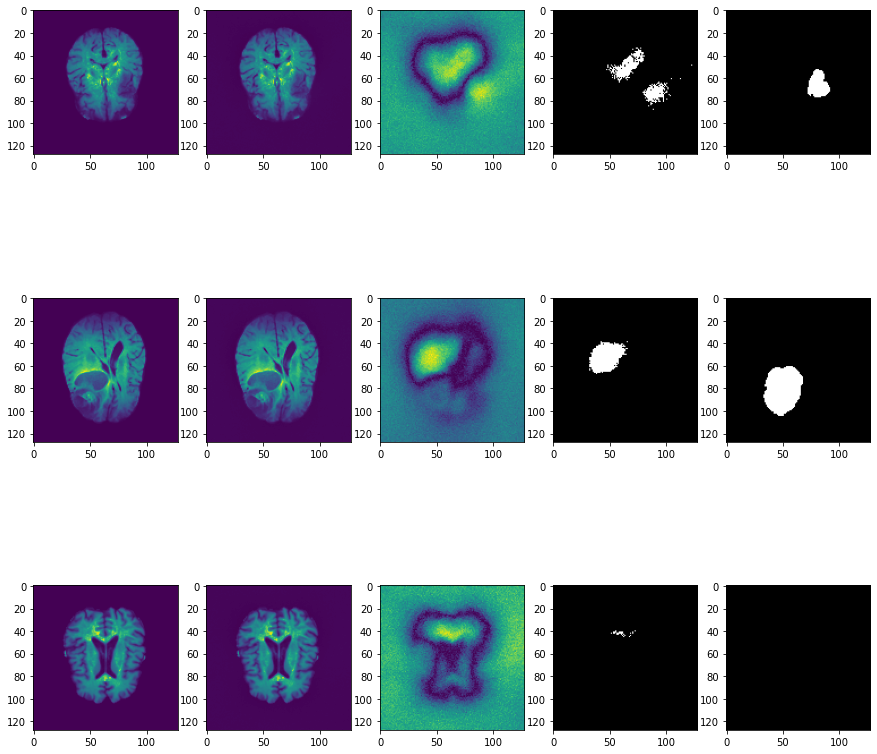

In [124]:
THRESHOLD = 0.02
WEIGHT = 3


f, axrr = plt.subplots(3,5)
f.set_figheight(15)
f.set_figwidth(15)

loader = enumerate(dl)
for i in range(3):
    batch, (img, mask) = next(loader)
    clean_mask = img
    img = img.to(device)
    
    clean_mask[clean_mask != 0] = 1
    
    mask=mask.to(device)
    decoded_mu = get_decoded_mu(img)
    img = img
    decoded_mu = decoded_mu
    restored = map_restoration_vae_type1(inpimg=img, decmu=decoded_mu, vae_prior=vae_model, device='cuda', riter=100, tvweight=WEIGHT, alpha=0.01)
    
    
    clean_mask = clean_mask.to(device)
    clean_mask = clean_mask
    #restored = torch.minimum(clean_mask, restored)
    rest_clone = restored.clone().detach()
    rest_clone[clean_mask == 0] = 0
    
    axrr[i][0].imshow(img[0][0].to('cpu').detach())
    axrr[i][1].imshow(restored[0][0].to('cpu').detach())
    diff = torch.abs(img-restored)
    print(torch.max(diff))
    axrr[i][2].imshow(diff[0][0].to('cpu').detach())
    diff[diff<THRESHOLD] = 0
    diff[diff>=THRESHOLD] = 1
    axrr[i][3].imshow(diff[0][0].to('cpu').detach(), cmap='gray')
    axrr[i][4].imshow(mask[0][0].to('cpu').detach(), cmap='gray')

## Thresholding

# Dice coeff

In [87]:
from tensorflow import keras

def dice_similarity(exp, pred):
    """
    Returns the Dice Similarity Coefficient between an image predicted by the
    model and its expected result.  Uses the formula:
    DSC = 2TP / (2TP + FP + FN)
    Where TP, FP and FN mean "true positive", "false positive" and 
    "false negative", respectively.
    Parameters
    ----------
    exp: numpy array of image data
        Data from the expected image.
    pred: numpy array of image data
        Data from the predicted image.
    Returns
    ----------
    The DSC between the two images.
    """
    # flatten to 1D arrays
    expected = keras.backend.batch_flatten(exp)
    predicted = keras.backend.batch_flatten(pred)
    predicted = keras.backend.round(predicted)

    expected_positive = keras.backend.sum(expected, axis=-1)
    predicted_positive = keras.backend.sum(predicted, axis=-1)

    # TP when both arrays share a positive at the index
    true_positive = keras.backend.sum(expected * predicted, axis=-1)

    # FN is any expected positives not guessed in TP
    false_negative = expected_positive - true_positive

    # FP is any predicted positive not part of TP
    false_positive = predicted_positive - true_positive

    numerator = 2 * true_positive + keras.backend.epsilon()
    denominator = 2 * true_positive + false_positive + false_negative + keras.backend.epsilon()
    return numerator / denominator

In [110]:
THRESHOLD = 0.02
WEIGHT = 3

dice_cumilation = 0
runner = 10
loader = enumerate(dl)
for i in tqdm(range(runner)):
    batch, (img, mask) = next(loader)
    clean_mask = img
    img = img.to(device)
    
    clean_mask[clean_mask != 0] = 1
    
    mask=mask.to(device)
    decoded_mu = get_decoded_mu(img)
    img = img
    decoded_mu = decoded_mu
    restored = map_restoration_vae_type1(inpimg=img, decmu=decoded_mu, vae_prior=vae_model, device='cuda', riter=100, tvweight=WEIGHT, alpha=0.01)
    
    #####
    # Get dice score
    diff = torch.abs(img-restored)
    diff[diff<THRESHOLD] = 0
    diff[diff>=THRESHOLD] = 1
    diff = diff.to('cpu').detach().numpy()
    og = mask.to('cpu').detach().numpy()
    score = dice_similarity(og, diff)
    #####
    dice_cumilation += score
dice_cumilation = dice_cumilation / runner


print(dice_cumilation)

100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

tf.Tensor([0.09894666], shape=(1,), dtype=float64)


In [117]:
thresholds = (np.linspace(0,0.5,30)).tolist()

In [118]:
dsc_list = []
for threshold in tqdm(thresholds):
    THRESHOLD = threshold
    WEIGHT = 3

    dice_cumilation = 0
    runner = 70
    loader = enumerate(dl)
    for i in range(runner):
        batch, (img, mask) = next(loader)
        clean_mask = img
        img = img.to(device)

        clean_mask[clean_mask != 0] = 1

        mask=mask.to(device)
        decoded_mu = get_decoded_mu(img)
        img = img
        decoded_mu = decoded_mu
        restored = map_restoration_vae_type1(inpimg=img, decmu=decoded_mu, vae_prior=vae_model, device='cuda', riter=100, tvweight=WEIGHT, alpha=0.01)

        #####
        # Get dice score
        diff = torch.abs(img-restored)
        diff[diff<THRESHOLD] = 0
        diff[diff>=THRESHOLD] = 1
        diff = diff.to('cpu').detach().numpy()
        og = mask.to('cpu').detach().numpy()
        score = dice_similarity(og, diff)
        #####
        dice_cumilation += score
    dice_cumilation = dice_cumilation / runner
    print(threshold, dice_cumilation)
    dsc_list.append(dice_cumilation)

  3%|▎         | 1/30 [02:29<1:12:05, 149.17s/it]

0.0 tf.Tensor([0.2350138], shape=(1,), dtype=float64)


  7%|▋         | 2/30 [04:57<1:09:28, 148.86s/it]

0.017241379310344827 tf.Tensor([0.13680002], shape=(1,), dtype=float64)


 10%|█         | 3/30 [07:26<1:06:59, 148.86s/it]

0.034482758620689655 tf.Tensor([0.00877782], shape=(1,), dtype=float64)


 13%|█▎        | 4/30 [09:55<1:04:31, 148.90s/it]

0.05172413793103448 tf.Tensor([4.42156505e-10], shape=(1,), dtype=float64)


 17%|█▋        | 5/30 [12:24<1:02:00, 148.83s/it]

0.06896551724137931 tf.Tensor([4.5076258e-10], shape=(1,), dtype=float64)


 20%|██        | 6/30 [14:53<59:32, 148.86s/it]  

0.08620689655172414 tf.Tensor([4.3793106e-10], shape=(1,), dtype=float64)


 23%|██▎       | 7/30 [17:22<57:03, 148.84s/it]

0.10344827586206896 tf.Tensor([4.29688181e-10], shape=(1,), dtype=float64)


 27%|██▋       | 8/30 [19:50<54:34, 148.82s/it]

0.12068965517241378 tf.Tensor([4.44482302e-10], shape=(1,), dtype=float64)


 30%|███       | 9/30 [22:19<52:07, 148.91s/it]

0.13793103448275862 tf.Tensor([4.42710887e-10], shape=(1,), dtype=float64)


 33%|███▎      | 10/30 [24:48<49:37, 148.89s/it]

0.15517241379310345 tf.Tensor([4.44344704e-10], shape=(1,), dtype=float64)


 37%|███▋      | 11/30 [27:17<47:09, 148.93s/it]

0.1724137931034483 tf.Tensor([4.48486357e-10], shape=(1,), dtype=float64)


 40%|████      | 12/30 [29:52<45:14, 150.80s/it]

0.1896551724137931 tf.Tensor([4.24189534e-10], shape=(1,), dtype=float64)


 43%|████▎     | 13/30 [32:22<42:38, 150.51s/it]

0.20689655172413793 tf.Tensor([4.43084825e-10], shape=(1,), dtype=float64)


 47%|████▋     | 14/30 [34:51<40:01, 150.08s/it]

0.22413793103448276 tf.Tensor([4.48552135e-10], shape=(1,), dtype=float64)


 50%|█████     | 15/30 [37:26<37:52, 151.51s/it]

0.24137931034482757 tf.Tensor([2.57144963e-10], shape=(1,), dtype=float64)


 53%|█████▎    | 16/30 [39:57<35:17, 151.28s/it]

0.25862068965517243 tf.Tensor([4.43902225e-10], shape=(1,), dtype=float64)


 57%|█████▋    | 17/30 [42:26<32:39, 150.73s/it]

0.27586206896551724 tf.Tensor([3.64828666e-10], shape=(1,), dtype=float64)


 60%|██████    | 18/30 [44:56<30:04, 150.34s/it]

0.29310344827586204 tf.Tensor([4.43477728e-10], shape=(1,), dtype=float64)


 63%|██████▎   | 19/30 [47:25<27:29, 149.92s/it]

0.3103448275862069 tf.Tensor([4.37435826e-10], shape=(1,), dtype=float64)


 67%|██████▋   | 20/30 [49:54<24:56, 149.67s/it]

0.3275862068965517 tf.Tensor([4.32866925e-10], shape=(1,), dtype=float64)


 67%|██████▋   | 20/30 [50:42<25:21, 152.12s/it]


KeyboardInterrupt: 

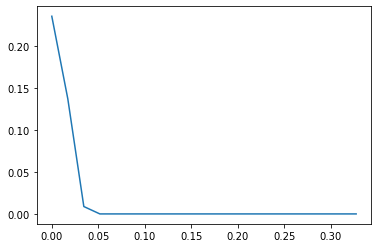

In [122]:
# threhold vs dsc
plt.plot(thresholds[0:len(dsc_list)], dsc_list)

In [121]:
len(thresholds)

30

## Changing MAP fn (-1* lambda_tv)

In [126]:
def map_restoration_vae_type1(inpimg, decmu, vae_prior, device='cuda', riter=100, tvweight=1, alpha=0.01):
    """
    :param inpimg: [batch, channels, width, height] Input image (image with lesion)
    :param decmu:  [batch, channels, width, height] Decoded mean for l2 loss calculation
    :param vae_prior: trained VAE prior
    :param device: computation device
    :param riter: reconstruction iters
    :param tvweight: tv_norm weight
    :param alpha: learning rate
    :return: Restored image
    """
    inpimg = nn.Parameter(inpimg, requires_grad=False)
    decmu = nn.Parameter(decmu.float(), requires_grad=False)
    X_i = nn.Parameter(inpimg.clone(), requires_grad=True)

    inpimg = inpimg.to(device)
    decmu = decmu.to(device)
    X_i = X_i.to(device)
    vae_prior = vae_prior.to(device)

    optimizer = optim.Adam([X_i], lr=alpha)
    for i in range(riter):
        _, z_mean, z_cov, _ = vae_prior(X_i.double())
        l2_loss = (decmu.view(-1, decmu.numel()) - X_i.view(-1, X_i.numel())).pow(2)
        kl_loss = -0.5 * torch.sum(1 + z_cov - z_mean.pow(2) - z_cov.exp())
        gradfn = (-1)*((torch.sum(l2_loss) + kl_loss) + tvweight * (-1)*total_variation((torch.subtract(X_i,inpimg).squeeze(1))))
        gradfn.backward()
        torch.clamp(X_i, -100, 100)
        optimizer.step()
        optimizer.zero_grad()
    return X_i

tensor(0.0485, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0367, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0347, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)


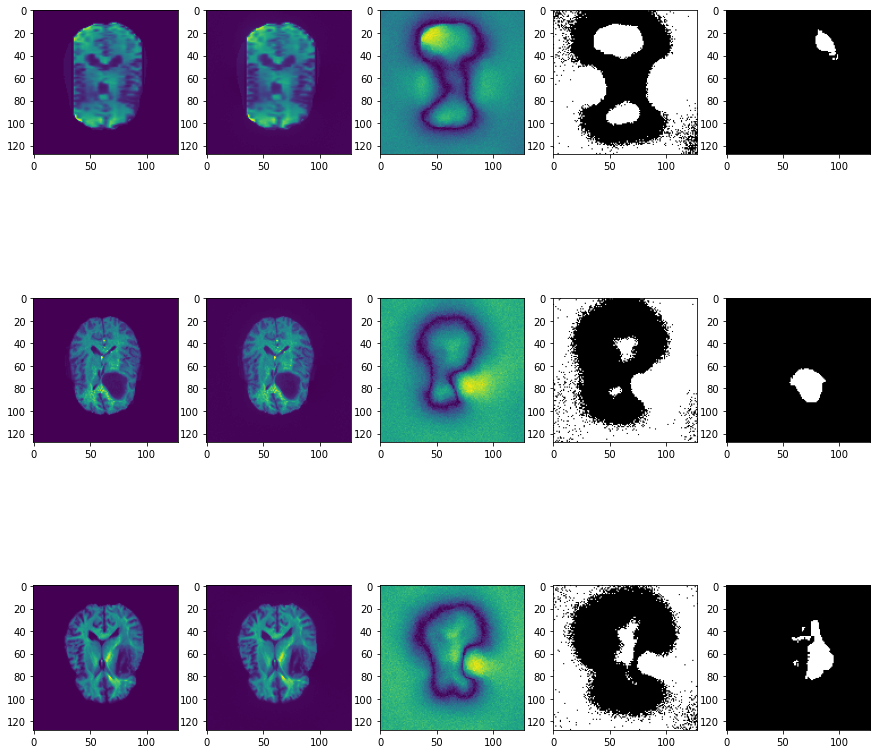

In [127]:
THRESHOLD = 0.02
WEIGHT = 3


f, axrr = plt.subplots(3,5)
f.set_figheight(15)
f.set_figwidth(15)

loader = enumerate(dl)
for i in range(3):
    batch, (img, mask) = next(loader)
    clean_mask = img
    img = img.to(device)
    
    clean_mask[clean_mask != 0] = 1
    
    mask=mask.to(device)
    decoded_mu = get_decoded_mu(img)
    img = img
    decoded_mu = decoded_mu
    restored = map_restoration_vae_type1(inpimg=img, decmu=decoded_mu, vae_prior=vae_model, device='cuda', riter=100, tvweight=WEIGHT, alpha=0.01)
    
    
    clean_mask = clean_mask.to(device)
    clean_mask = clean_mask
    #restored = torch.minimum(clean_mask, restored)
    rest_clone = restored.clone().detach()
    rest_clone[clean_mask == 0] = 0
    
    axrr[i][0].imshow(img[0][0].to('cpu').detach())
    axrr[i][1].imshow(restored[0][0].to('cpu').detach())
    diff = torch.abs(img-restored)
    print(torch.max(diff))
    axrr[i][2].imshow(diff[0][0].to('cpu').detach())
    diff[diff<THRESHOLD] = 0
    diff[diff>=THRESHOLD] = 1
    axrr[i][3].imshow(diff[0][0].to('cpu').detach(), cmap='gray')
    axrr[i][4].imshow(mask[0][0].to('cpu').detach(), cmap='gray')

In [129]:
thresholds = (np.linspace(0,0.03,20)).tolist()

In [130]:
dsc_list = []
for threshold in tqdm(thresholds):
    THRESHOLD = threshold
    WEIGHT = 3

    dice_cumilation = 0
    runner = 70
    loader = enumerate(dl)
    for i in range(runner):
        batch, (img, mask) = next(loader)
        clean_mask = img
        img = img.to(device)

        clean_mask[clean_mask != 0] = 1

        mask=mask.to(device)
        decoded_mu = get_decoded_mu(img)
        img = img
        decoded_mu = decoded_mu
        restored = map_restoration_vae_type1(inpimg=img, decmu=decoded_mu, vae_prior=vae_model, device='cuda', riter=100, tvweight=WEIGHT, alpha=0.01)

        #####
        # Get dice score
        diff = torch.abs(img-restored)
        diff[diff<THRESHOLD] = 0
        diff[diff>=THRESHOLD] = 1
        diff = diff.to('cpu').detach().numpy()
        og = mask.to('cpu').detach().numpy()
        score = dice_similarity(og, diff)
        #####
        dice_cumilation += score
    dice_cumilation = dice_cumilation / runner
    print(threshold, dice_cumilation)
    dsc_list.append(dice_cumilation)

  5%|▌         | 1/20 [02:29<47:12, 149.09s/it]

0.0 tf.Tensor([0.23481732], shape=(1,), dtype=float64)


 10%|█         | 2/20 [04:58<44:43, 149.09s/it]

0.0015789473684210526 tf.Tensor([0.21706911], shape=(1,), dtype=float64)


 15%|█▌        | 3/20 [07:26<42:11, 148.93s/it]

0.003157894736842105 tf.Tensor([0.2271332], shape=(1,), dtype=float64)


 20%|██        | 4/20 [09:55<39:41, 148.85s/it]

0.004736842105263157 tf.Tensor([0.22175248], shape=(1,), dtype=float64)


 25%|██▌       | 5/20 [12:24<37:13, 148.93s/it]

0.00631578947368421 tf.Tensor([0.21774068], shape=(1,), dtype=float64)


 30%|███       | 6/20 [14:53<34:44, 148.90s/it]

0.007894736842105263 tf.Tensor([0.21264864], shape=(1,), dtype=float64)


 35%|███▌      | 7/20 [17:22<32:15, 148.88s/it]

0.009473684210526315 tf.Tensor([0.22159105], shape=(1,), dtype=float64)


 40%|████      | 8/20 [19:51<29:47, 148.93s/it]

0.011052631578947368 tf.Tensor([0.20493826], shape=(1,), dtype=float64)


 45%|████▌     | 9/20 [22:20<27:17, 148.87s/it]

0.01263157894736842 tf.Tensor([0.21060741], shape=(1,), dtype=float64)


 50%|█████     | 10/20 [24:48<24:48, 148.84s/it]

0.014210526315789474 tf.Tensor([0.19065899], shape=(1,), dtype=float64)


 55%|█████▌    | 11/20 [27:17<22:19, 148.88s/it]

0.015789473684210527 tf.Tensor([0.1964265], shape=(1,), dtype=float64)


 60%|██████    | 12/20 [29:46<19:50, 148.82s/it]

0.017368421052631578 tf.Tensor([0.17749316], shape=(1,), dtype=float64)


 65%|██████▌   | 13/20 [32:15<17:21, 148.84s/it]

0.01894736842105263 tf.Tensor([0.165488], shape=(1,), dtype=float64)


 70%|███████   | 14/20 [34:44<14:53, 148.93s/it]

0.020526315789473684 tf.Tensor([0.15031149], shape=(1,), dtype=float64)


 75%|███████▌  | 15/20 [37:13<12:24, 148.86s/it]

0.022105263157894735 tf.Tensor([0.12946971], shape=(1,), dtype=float64)


 80%|████████  | 16/20 [39:42<09:55, 148.86s/it]

0.02368421052631579 tf.Tensor([0.12742723], shape=(1,), dtype=float64)


 85%|████████▌ | 17/20 [42:19<07:34, 151.49s/it]

0.02526315789473684 tf.Tensor([0.14407328], shape=(1,), dtype=float64)


 90%|█████████ | 18/20 [44:50<05:02, 151.14s/it]

0.026842105263157893 tf.Tensor([0.15134858], shape=(1,), dtype=float64)


 95%|█████████▌| 19/20 [47:19<02:30, 150.70s/it]

0.028421052631578948 tf.Tensor([0.14177003], shape=(1,), dtype=float64)


100%|██████████| 20/20 [49:48<00:00, 149.45s/it]

0.03 tf.Tensor([0.12781068], shape=(1,), dtype=float64)


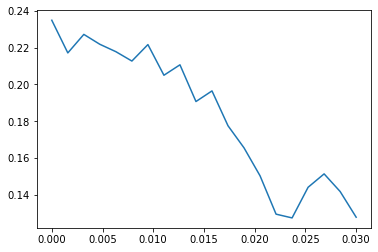

In [131]:
# threhold vs dsc
plt.plot(thresholds[0:len(dsc_list)], dsc_list)